# Experiment 2

This python notebook generates the results and computes statistics for Experiment 1 in deBettencourt MT, Norman KA, Turk-Browne NB (in prep)

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import scipy
import scipy.io as sio
import scikits.bootstrap as bootstrap  
import statsmodels.api as sm

from paper_statistics import resamplingStatistics, paramStatistics
from paper_plotting import make_plot_pretty, savefig, plotSpread
from paper_behavior import aprime, find_freq_categ, convertKey2Resp

In [2]:
%matplotlib inline 

plt.rcParams.update({'font.size': 14})
rc('text', usetex=False)

if os.path.isfile("/Library/Fonts/HelveticaNeue.ttf"): prop = fm.FontProperties(fname='/Library/Fonts/HelveticaNeue.ttf')
else: prop = fm.FontProperties(fname='/Library/Fonts/Arial.ttf')

In [3]:
#preset some details of the experiment

subjNums = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27])
#subject 26 excluded due to poor behavior (>3 standard deviations below mean)

nSubj = subjNums.size #total number of subjects

dataDir = 'data_expt2/' #directory of data files
figDir = 'figures/' #directory to save figures

nTrials = 500

nSamples = 100000 # number of resampling iterations 
nShifts = 3 #number of trials before an incorrect response

In [4]:
#sustained attention phase: load data, compute overall behavioral performance metrics

#preallocate some variables
categs = {}
categFreq, categInfreq = np.ones([nSubj]).astype(int)*-1, np.ones([nSubj]).astype(int)*-1
trialsFreq, trialsInfreq = {}, {}
accs, accsFreq, accsInfreq = {}, {}, {}
h, cr = np.empty(nSubj) * np.nan, np.empty(nSubj) * np.nan

for iSubj in range(0,nSubj):
    #directory where data is stored
    subjDir = dataDir + str(int(subjNums[iSubj])) + '/'
    
    #load files
    fn = glob.glob( ( subjDir + 'blockdata*' ) )
    matContents = sio.loadmat(fn[0],struct_as_record=False)
    attData = matContents['blockData']

    #category of all trials (1=scenes, 2 = faces)
    categs[iSubj] = attData[0,0].categs[0]
    
    #determine which category was frequent, and which was infrequent by calculating the mode across all trials
    categFreq[iSubj],categInfreq[iSubj] = find_freq_categ(categs[iSubj])
    
    #locations of frequent and infrequent trials
    trialsFreq[iSubj] = np.where(np.equal(categs[iSubj],categFreq[iSubj]))[0]
    trialsInfreq[iSubj] = np.where(np.equal(categs[iSubj],categInfreq[iSubj]))[0]
    
    #behavioral accuracy of all trials (1 = correct, 0 = incorrect)
    accs[iSubj] = attData[0,0].accs[0]
    
    #accuracy of frequent and infrequent trials
    accsFreq[iSubj] = [accs[iSubj][i] for i in trialsFreq[iSubj]]
    accsInfreq[iSubj] = [accs[iSubj][i] for i in trialsInfreq[iSubj]]

    #summary of sustained attention performance
    h[iSubj] = np.mean([accs[iSubj][i] for i in trialsFreq[iSubj]]) #hit rate
    cr[iSubj] = np.mean([accs[iSubj][i] for i in trialsInfreq[iSubj]]) #correct rejection rate
    
#Calculate sensitivity for sustained attention task (A')
m = np.subtract(1,h) #miss rate
fa = np.subtract(1,cr) #false alarm rate
A = aprime(h,fa) #aprime

#compute confidence intervals for sustained attention performance
h_CIs = bootstrap.ci(data=(h), statfunction=scipy.mean,n_samples=nSamples)
m_CIs = bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=nSamples)
fa_CIs = bootstrap.ci(data=(fa), statfunction=scipy.mean,n_samples=nSamples)
cr_CIs = bootstrap.ci(data=(cr), statfunction=scipy.mean,n_samples=nSamples)
A_CIs = bootstrap.ci(data=(A), statfunction=scipy.mean,n_samples=nSamples)

#print overall sustained attention performance
print "Overall sustained attention phase performance:"
print "\t Hit rate =\t%.2f, \t95%% CIs %.2f,%.2f " % ( round(np.ndarray.mean(h),2) , round(h_CIs[0],2) , round(h_CIs[1],2) )
print "\t Miss rate =\t%.2f, \t95%% CIs %.2f,%.2f" % ( round(np.ndarray.mean(m),2) , round(m_CIs[0],2) , round(m_CIs[1],2) )
print "\t FA rate =\t%.2f, \t95%% CIs %.2f,%.2f" % ( round(np.ndarray.mean(fa),2) , round(fa_CIs[0],2) , round(fa_CIs[1],2) )
print "\t CR rate =\t%.2f, \t95%% CIs %.2f,%.2f" % ( round(np.ndarray.mean(cr),2) , round(cr_CIs[0],2) , round(cr_CIs[1],2) )
print "\t A' = \t\t%.2f, \t95%% CIs %.2f,%.2f" % ( round(np.ndarray.mean(A),2) , round(A_CIs[0],2) , round(A_CIs[1],2) )

Overall sustained attention phase performance:
	 Hit rate =	0.98, 	95% CIs 0.97,0.98 
	 Miss rate =	0.02, 	95% CIs 0.02,0.03
	 FA rate =	0.38, 	95% CIs 0.32,0.43
	 CR rate =	0.62, 	95% CIs 0.57,0.68
	 A' = 		0.89, 	95% CIs 0.88,0.91


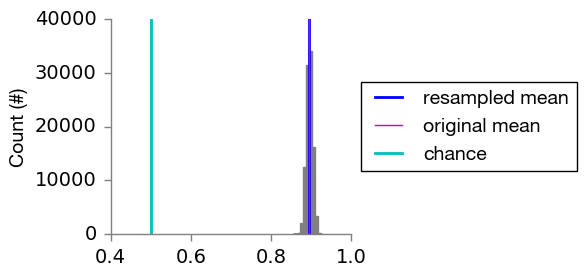

Sustained attention performance (A') vs chance (.5): p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.89
Parametric statistical result: T = 49.1, p = 8.8E-25


In [5]:
# Compute statistics on sensitivity for sustained attention task 

data = A
chance = .5

#nonparametric statistics - by resampling participants with replacement
resampledA,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Sustained attention performance (A') vs chance (.5): p = %.2E" %p

#parametric statistics
paramStatistics(data,chance)

Calculate error rate for task

In [6]:
#error rate in sustained attention phase for trials triggered based on faster or slower RTs

#preallocate some variables
trialsTriggeredSlow, trialsTriggeredFast = {}, {}
accsTriggeredSlow, accsTriggeredFast = {}, {}
crTriggeredSlow, crTriggeredFast = np.empty(nSubj) * np.nan, np.empty(nSubj) * np.nan


for iSubj in range(0,nSubj):
    #directory where data is stored
    subjDir = dataDir + str(int(subjNums[iSubj])) + '/'
    
    #load files
    fn = glob.glob( ( subjDir + 'blockdata*' ) )
    matContents = sio.loadmat(fn[0],struct_as_record=False)
    attData = matContents['blockData']

    #find the location of trials that were triggered
    trialsTriggeredSlow[iSubj] = np.where(np.equal(attData[0,0].remember[0],1))[0]
    trialsTriggeredFast[iSubj] = np.where(np.equal(attData[0,0].forget[0],1))[0]
    
    #accuracy of triggered trials
    accsTriggeredSlow[iSubj] = [accs[iSubj][i] for i in trialsTriggeredSlow[iSubj]]
    accsTriggeredFast[iSubj] = [accs[iSubj][i] for i in trialsTriggeredFast[iSubj]]
    
    #correct rejection rate
    crTriggeredSlow[iSubj] = np.mean(accsTriggeredSlow[iSubj]) 
    crTriggeredFast[iSubj] = np.mean(accsTriggeredFast[iSubj]) 
    
#compute confidence intervals for sustained attention performance

faTriggeredSlow = 1-crTriggeredSlow
faTriggeredFast = 1-crTriggeredFast

errDiff = (faTriggeredFast) - (faTriggeredSlow)

faTriggeredSlow_CIs = bootstrap.ci(data=(faTriggeredSlow), statfunction=scipy.mean,n_samples=nSamples)
faTriggeredFast_CIs = bootstrap.ci(data=(faTriggeredFast), statfunction=scipy.mean,n_samples=nSamples)

print("Error rate for trials triggered with fast RTs: %.2f, \t95%% CIs %.2f,%.2f" %( round(np.mean(faTriggeredFast),2), round(faTriggeredFast_CIs[0],2), round(faTriggeredFast_CIs[1],2) ))
print("Error rate for trials triggered with slow RTs: %.2f, \t95%% CIs %.2f,%.2f" %( round(np.mean(faTriggeredSlow),2), round(faTriggeredSlow_CIs[0],2), round(faTriggeredSlow_CIs[1],2) ))

Error rate for trials triggered with fast RTs: 0.66, 	95% CIs 0.55,0.77
Error rate for trials triggered with slow RTs: 0.26, 	95% CIs 0.21,0.32


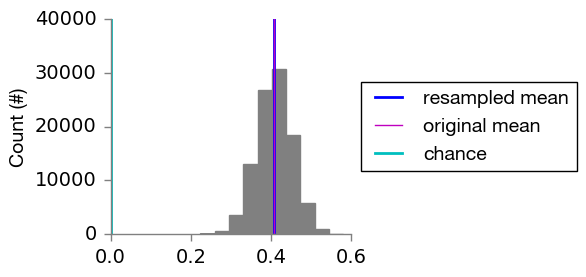

Sustained attention performance (A') vs chance (.5): p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.43
Parametric statistical result: T = 9.0, p = 5.0E-09


In [7]:
# Compute statistics on error rate difference (fast - slow)

data = errDiff 
chance = 0

#nonparametric statistics - by resampling participants with replacement
resampledErrDiff,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Sustained attention performance (A') vs chance (.5): p = %.2E" %p

#parametric statistics
paramStatistics(data,chance)

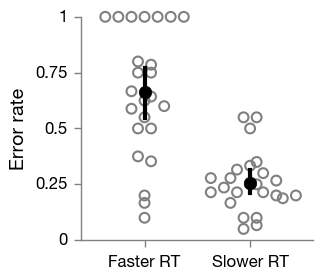

In [8]:
#plot errors for trials triggered based on faster vs. slower RTs (Figure 4a)

fig = plt.figure(figsize=(6,3))
gs = plt.GridSpec(1,2)
ax0 = plt.subplot(gs[0])
x = np.zeros(24)
y = faTriggeredFast
x_swarm,a,b = plotSpread(x,y)
ax0.scatter(x_swarm+.375,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
x = np.zeros(24)
y = faTriggeredSlow
x_swarm,a,b = plotSpread(x,y)
ax0.scatter(x_swarm+.625,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
make_plot_pretty(ax0,xt=(.375,.625),yt=(0,.25,.5,.75,1),ytl=(0,.25,.5,.75,1),xlim=(.225,.775),ylim=(0,1),xtl=('Faster RT','Slower RT'),yl=('Error rate'))
ax0.plot((.375,.625),((faTriggeredFast).mean(),(faTriggeredSlow).mean()),'o',color='k',markersize=9);
ax0.plot([.375,.375], faTriggeredFast_CIs, 'k-',linewidth=3);
ax0.plot([.625,.625], faTriggeredSlow_CIs, 'k-',linewidth=3);

Average list position = 241 for trials triggered due to slow RTs
Average list position = 248 for trials triggered due to fast RTs


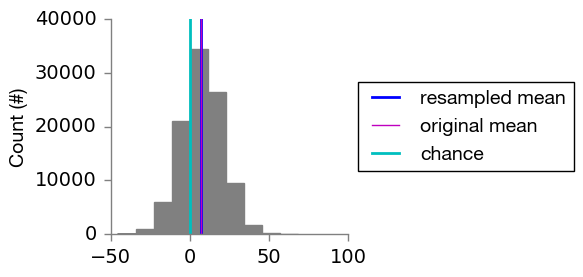

The difference in the average appearance of slow vs. fast trials: p = 0.28
Fails to reject the null hypothesis that the data is normally distributed, p = 0.99
Parametric statistical result: T = 0.6, p = 5.8E-01


In [9]:
#calculate whether there was a difference in list position for trials triggered due to fast vs. slow RTs 

avgTrialNumSlow = np.empty(nSubj)
avgTrialNumFast = np.empty(nSubj)

for iSubj in range(0,nSubj):
    avgTrialNumSlow[iSubj] = np.mean(trialsTriggeredSlow[iSubj])
    avgTrialNumFast[iSubj] = np.mean(trialsTriggeredFast[iSubj])

print "Average list position = %i for trials triggered due to slow RTs" %np.round(np.mean(avgTrialNumSlow))
print "Average list position = %i for trials triggered due to fast RTs" %np.round(np.mean(avgTrialNumFast))

data = avgTrialNumFast-avgTrialNumSlow
chance = 0

#nonparametric statistics
resampledTrialNumDiff,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "The difference in the average appearance of slow vs. fast trials: p = %.2F" %p

#parametric statistics
paramStatistics(avgTrialNumFast-avgTrialNumSlow,chance)

Mean # trials since last infrequent trials, slow condition: 13.51
Mean # trials since last infrequent trials, fast condition: 19.81


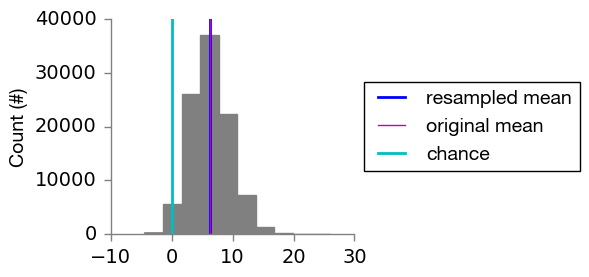

The average distance since an infrequent trial for fast vs. slow trials: 6
The reliability of this difference p = 0.013
Rejects the null hypothesis that the data is normally distributed, p = 1.66E-03
Parametric statistical result: T = 1.9, p = 6.4E-02


In [10]:
#calculate distance since last infrequent trial, separately for fast and slow condition

allInfreqTriggeredTrials = {}
distBtwnInfreqTriggeredTrials = np.empty(nSubj)
distBtwnPrevInfreqTrialSlow,distBtwnPrevInfreqTrialFast = {},{}
meanDistPrevInfreqTrialSlow,meanDistPrevInfreqTrialFast = np.empty(nSubj), np.empty(nSubj)

for iSubj in range(0,nSubj):
    allInfreqTriggeredTrials[iSubj] = np.sort(np.append(trialsTriggeredSlow[iSubj],trialsTriggeredFast[iSubj]))
    distBtwnInfreqTriggeredTrials[iSubj] = np.mean(np.diff(allInfreqTriggeredTrials[iSubj]))

    #for each trial, find the most recent trial
    tempPrevTrialDist = np.empty(np.size(trialsTriggeredSlow[iSubj]))
    for i in range(0,np.size(trialsTriggeredSlow[iSubj])):
        tempDist = trialsInfreq[iSubj]-trialsTriggeredSlow[iSubj][i]
        tempDist = tempDist[tempDist<0]
        tempDist = tempDist[-1]*-1
        tempPrevTrialDist[i] = tempDist
    
    distBtwnPrevInfreqTrialSlow[iSubj] = tempPrevTrialDist
    
    tempPrevTrialDist = np.empty(np.size(trialsTriggeredFast[iSubj]))
    for i in range(0,np.size(trialsTriggeredFast[iSubj])):
        tempDist = trialsInfreq[iSubj]-trialsTriggeredFast[iSubj][i]
        tempDist = tempDist[tempDist<0]
        tempDist = tempDist[-1]*-1
        tempPrevTrialDist[i] = tempDist
    
    distBtwnPrevInfreqTrialFast[iSubj] = tempPrevTrialDist
    
    meanDistPrevInfreqTrialSlow[iSubj] = np.mean(distBtwnPrevInfreqTrialSlow[iSubj])
    meanDistPrevInfreqTrialFast[iSubj] = np.mean(distBtwnPrevInfreqTrialFast[iSubj])
    

print "Mean # trials since last infrequent trials, slow condition: %.2F" %np.mean(meanDistPrevInfreqTrialSlow)
print "Mean # trials since last infrequent trials, fast condition: %.2F" %np.mean(meanDistPrevInfreqTrialFast)
    
data = meanDistPrevInfreqTrialFast-meanDistPrevInfreqTrialSlow
chance = 0

#nonparametric statistics
resampledErrDiff,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "The average distance since an infrequent trial for fast vs. slow trials: %i" %np.mean(data)
print "The reliability of this difference p = %.3F" %p

#parametric statistics
paramStatistics(meanDistPrevInfreqTrialFast-meanDistPrevInfreqTrialSlow,chance)

Mean logistic relationship between distance from infrequent trial 
to accuracy in sustained attention phase:
= 0.03, (-0.14, 0.35)


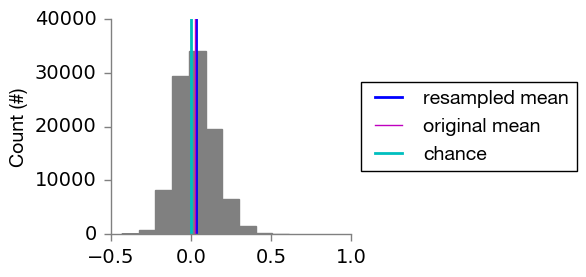

Resampling statistics of relationship between # trials to accuracy: p = 0.43
Rejects the null hypothesis that the data is normally distributed, p = 6.95E-05
Parametric statistical result: T = 0.2, p = 8.1E-01


In [11]:
#calculate relationship between # trials since an infrequent trial and attention accuracy
#note: slow trials only

X,y,est = {},{},{}
paramsSlow = np.empty([2,nSubj])
for iSubj in range(0,nSubj):    
    #logistic fit
    X[iSubj] = distBtwnPrevInfreqTrialSlow[iSubj]
    y[iSubj] = np.asarray(accsTriggeredSlow[iSubj])
    est[iSubj] = sm.GLM(np.vstack([y[iSubj],1-y[iSubj]]).T,sm.add_constant(X[iSubj]),family=sm.families.Binomial()).fit()
    paramsSlow[:,iSubj] = est[iSubj].params
    
#summarize & report reliability (# trials since an infrequent trial and attention accuracy)
data = paramsSlow[1,np.where(faTriggeredFast!=1)][0] #only subjects with correct response
chance = 0

betaTriggeredSlow_CIs = bootstrap.ci(data=(data), statfunction=scipy.mean,n_samples=nSamples)

print "Mean logistic relationship between distance from infrequent trial \nto accuracy in sustained attention phase:"
print "= %.2F, (%.2f, %.2f)"%( np.mean(data),betaTriggeredSlow_CIs[0],betaTriggeredSlow_CIs[1] )

#nonparametric statistcs
resampledBeta,p = resamplingStatistics(data,chance,np.size(np.where(faTriggeredFast!=1)),nSamples)
print "Resampling statistics of relationship between # trials to accuracy: p = %.2F" %p

#parametric statistics
paramStatistics(data,chance)

Mean logistic relationship between distance from infrequent trial 
to accuracy in sustained attention phase:
= -0.01, (-0.19, 0.34)


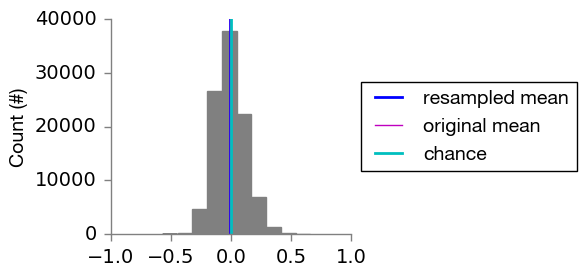

Resampling statistics of relationship between # trials to accuracy: p = 0.56
Rejects the null hypothesis that the data is normally distributed, p = 9.46E-05
Parametric statistical result: T = -0.1, p = 9.4E-01


In [12]:
#calculate relationship between # trials since an infrequent trial and attention accuracy
#note: fast trials only

X,y,est = {},{},{}
paramsFast = np.empty([2,nSubj])
for iSubj in range(0,nSubj):    
    #logistic fit
    X[iSubj] = distBtwnPrevInfreqTrialFast[iSubj]
    y[iSubj] = np.asarray(accsTriggeredFast[iSubj])
    est[iSubj] = sm.GLM(np.vstack([y[iSubj],1-y[iSubj]]).T,sm.add_constant(X[iSubj]),family=sm.families.Binomial()).fit()
    paramsFast[:,iSubj] = est[iSubj].params
    
#summarize & report reliability
data = paramsFast[1,np.where(faTriggeredFast!=1)][0] #only subjects with correct response
chance = 0

betaTriggeredFast_CIs = bootstrap.ci(data=(data), statfunction=scipy.mean,n_samples=nSamples)

print "Mean logistic relationship between distance from infrequent trial \nto accuracy in sustained attention phase:"
print "= %.2F, (%.2f, %.2f)"%( np.mean(data),betaTriggeredFast_CIs[0],betaTriggeredFast_CIs[1] )

#nonparametric statistics
resampledBeta,p = resamplingStatistics(data,chance,np.size(np.where(faTriggeredFast!=1)),nSamples)
print "Resampling statistics of relationship between # trials to accuracy: p = %.2F" %p

#parametric statistics
paramStatistics(data,chance)

In [13]:
#Subsequent memory test: load data, compute overall behavioral performance per participant

#high-confidence old resps only
thresh = 4 

#preallocate variables
memCategs, memResps, attOrder, nTrialsPerCateg = {}, {}, {}, {}
hFreq, faFreq, hInfreq, faInfreq = np.empty(nSubj), np.empty(nSubj), np.empty(nSubj), np.empty(nSubj)
memTrialsTriggeredSlow, memTrialsTriggeredFast = {}, {}
accSustAttnTriggeredSlow, accSustAttnTriggeredFast = np.empty(nSubj), np.empty(nSubj)
memRespsTriggeredSlow, memRespsTriggeredFast = {}, {}
propRememTriggeredSlow, propRememTriggeredFast = np.empty(nSubj), np.empty(nSubj)
subjCorrBothConds = np.empty(nSubj)
propRememTriggeredSlowAcc, propRememTriggeredFastAcc = np.empty(nSubj), np.empty(nSubj)

for iSubj in range(0,nSubj):
    iSubjNum = subjNums[iSubj]
    subjDir = dataDir + str(int(subjNums[iSubj])) + '/'
    
    fn = glob.glob( ( subjDir + 'memdata*' ) )
    matContents = sio.loadmat(fn[0],struct_as_record=False)
    memData = matContents['memData']
    
    memCategs[iSubj] = memData[0,0].memCategs[0] #memory category, 1 = old freq, 2 = old infreq, 3 = new freq, 4 = new infreq
    keys = memData[0,0].resps #which response the participant made
    
    memResps[iSubj] = np.array(map(convertKey2Resp,keys[0])) #convert from keycode to response number
    
    attOrder[iSubj] = memData[0,0].attOrder[0]-1 #offset to account for python vs matlab indicing    
    
    #number of trials per memory category
    nTrialsPerCateg[iSubj] = [np.sum(np.equal(memCategs[iSubj],i+1)) for i in range(0,4)]
    
    #resps per memory category
    respsFrequentOld = [memResps[iSubj][i] for i in np.where(np.equal(memCategs[iSubj],1))[0]]
    respsInfrequentOld = [memResps[iSubj][i] for i in np.where(np.equal(memCategs[iSubj],2))[0]]
    respsFrequentNew = [memResps[iSubj][i] for i in np.where(np.equal(memCategs[iSubj],3))[0]]
    respsInfrequentNew = [memResps[iSubj][i] for i in np.where(np.equal(memCategs[iSubj],4))[0]]
    
    hFreq[iSubj] = float(np.sum(np.greater_equal(respsFrequentOld,thresh))) / float(nTrialsPerCateg[iSubj][0])
    faFreq[iSubj] =float(np.sum(np.greater_equal(respsFrequentNew,thresh))) / float(nTrialsPerCateg[iSubj][2])

    hInfreq[iSubj] = float(np.sum(np.greater_equal(respsInfrequentOld,thresh))) / float(nTrialsPerCateg[iSubj][1])
    faInfreq[iSubj] =float(np.sum(np.greater_equal(respsInfrequentNew,thresh))) / float(nTrialsPerCateg[iSubj][3])
    
    #find location of memory trials triggered due to fast/slow RTs
    memTrialsTriggeredSlow[iSubj] = np.in1d(attOrder[iSubj],trialsTriggeredSlow[iSubj], assume_unique=True)
    memTrialsTriggeredFast[iSubj] = np.in1d(attOrder[iSubj],trialsTriggeredFast[iSubj], assume_unique=True)
    
    #find accuracy during attention phase
    accSustAttnTriggeredSlow[iSubj] = np.mean(accs[iSubj][attOrder[iSubj][memTrialsTriggeredSlow[iSubj]].astype(int)])
    accSustAttnTriggeredFast[iSubj] = np.mean(accs[iSubj][attOrder[iSubj][memTrialsTriggeredFast[iSubj]].astype(int)])
    
    #find accuracy during memory phase
    memRespsTriggeredSlow[iSubj] = memResps[iSubj][memTrialsTriggeredSlow[iSubj]]
    memRespsTriggeredFast[iSubj] = memResps[iSubj][memTrialsTriggeredFast[iSubj]]

    #find subjects with at least one correct response in both attentional states
    propRememTriggeredSlow[iSubj] = float(np.sum(np.greater_equal(memResps[iSubj][memTrialsTriggeredSlow[iSubj]],thresh)))/np.sum(memTrialsTriggeredSlow[iSubj])
    propRememTriggeredFast[iSubj] = float(np.sum(np.greater_equal(memResps[iSubj][memTrialsTriggeredFast[iSubj]],thresh)))/np.sum(memTrialsTriggeredFast[iSubj])
    
    #identify whether subjects made one correct response in sustained attention condition for both fast and slow trials
    if (accSustAttnTriggeredSlow[iSubj]>0) & (accSustAttnTriggeredFast[iSubj]>0):
        subjCorrBothConds[iSubj]=1
    else:
        subjCorrBothConds[iSubj]=0
    
    #correct responses only
    if subjCorrBothConds[iSubj]==1:
        #memory performance, only for trials triggered due to slow responses with correct responses
        tempMemResps = memResps[iSubj][memTrialsTriggeredSlow[iSubj]]
        tempLocAcc = np.where(accs[iSubj][attOrder[iSubj][memTrialsTriggeredSlow[iSubj]].astype(int)]==1)
        tempMemRespsWhereAcc = tempMemResps[tempLocAcc]
        propRememTriggeredSlowAcc[iSubj] = float(np.sum(np.greater_equal(tempMemRespsWhereAcc,thresh)))/np.size(tempLocAcc)

        #memory performance, only for trials triggered due to fast responses with correct responses
        tempMemResps = memResps[iSubj][memTrialsTriggeredFast[iSubj]]
        tempLocAcc = np.where(accs[iSubj][attOrder[iSubj][memTrialsTriggeredFast[iSubj]].astype(int)]==1)
        tempMemRespsWhereAcc = tempMemResps[tempLocAcc]
        propRememTriggeredFastAcc[iSubj] = float(np.sum(np.greater_equal(tempMemRespsWhereAcc,thresh)))/np.size(tempLocAcc)

    else:
        propRememTriggeredSlowAcc[iSubj]=float('nan')
        propRememTriggeredFastAcc[iSubj]=float('nan')

In [14]:
#compute memory performance

aFreq = aprime(hFreq,faFreq)
aInfreq = aprime(hInfreq,faInfreq)

aDiff = aInfreq - aFreq

#compute confidence intervals
aFreq_CIs = bootstrap.ci(data=(aFreq), statfunction=scipy.mean,n_samples=nSamples)
aInfreq_CIs = bootstrap.ci(data=(aInfreq), statfunction=scipy.mean,n_samples=nSamples)

#print overall memory performance:
print "Overall memory phase performance:"
print "A' frequent = \t%.2f, \t95%% CIs %.2f,%.2f" % ( round(np.ndarray.mean(aFreq),2) , round(aFreq_CIs[0],2) , round(aFreq_CIs[1],2) )
print "A' infrequent=\t%.2f, \t95%% CIs %.2f,%.2f" % ( round(np.ndarray.mean(aInfreq),2) , round(aInfreq_CIs[0],2) , round(aInfreq_CIs[1],2) )

Overall memory phase performance:
A' frequent = 	0.71, 	95% CIs 0.67,0.74
A' infrequent=	0.80, 	95% CIs 0.78,0.82


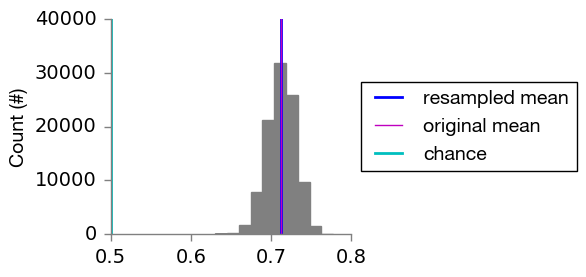

Memory sensitivity for frequent items above chance (.5): p = 1.00E-05
Rejects the null hypothesis that the data is normally distributed, p = 1.68E-02
Parametric statistical result: T = 11.8, p = 2.9E-11


In [15]:
#Compute statistics on memory sensitivity for frequent items 

data = aFreq
chance = .5

#non-parametric by resampling participants with replacement
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Memory sensitivity for frequent items above chance (.5): p = %.2E" %p

#parametric
paramStatistics(data,chance)

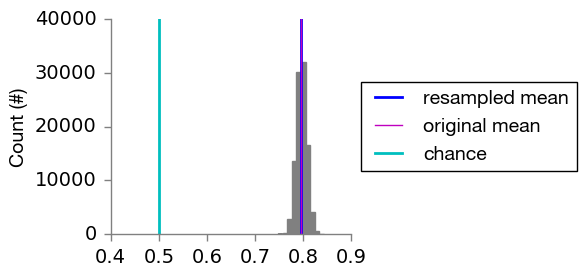

Memory sensitivity for infrequent items above chance (.5): p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.69
Parametric statistical result: T = 27.1, p = 5.8E-19


In [16]:
#Compute statistics on memory sensitivity for infrequent items 

data = aInfreq
chance = .5

#non-parametric by resampling participants with replacement
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Memory sensitivity for infrequent items above chance (.5): p = %.2E" %p

#parametric
paramStatistics(data,chance)

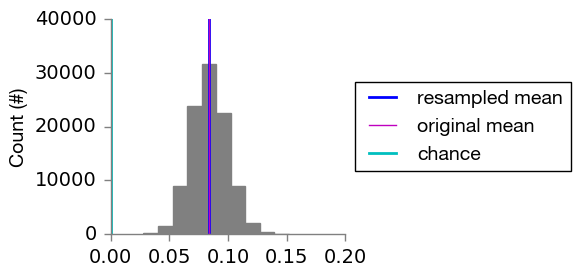

Memory sensitivity for infrequent items > frequent items: p = 1.00E-05
Fails to reject the null hypothesis that the data is normally distributed, p = 0.62
Parametric statistical result: T = 5.4, p = 1.6E-05


In [17]:
#Compute statistics on memory sensitivity differences (infrequent items > frequent items)

data = aInfreq-aFreq
chance = 0

#non-parametric - by resampling participants with replacement
resampled,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Memory sensitivity for infrequent items > frequent items: p = %.2E" %p

#parametric
paramStatistics(data,chance)

In [18]:
#print memory performance for trials triggered due to fast vs. slow RTs

propRememTriggeredFast_CIs = bootstrap.ci(data=(propRememTriggeredFast), statfunction=scipy.mean,n_samples=nSamples)
propRememTriggeredSlow_CIs = bootstrap.ci(data=(propRememTriggeredSlow), statfunction=scipy.mean,n_samples=nSamples)

print "Memory performance for trials triggered due to fast RTs:"
print "Proportion remembered = %d%%, \t95%% CIs %.0f,%.0f%%" % ( round(np.ndarray.mean(propRememTriggeredFast),2)*100,round(propRememTriggeredFast_CIs[0],2)*100,round(propRememTriggeredFast_CIs[1],2)*100 )
print "\n"
print "Memory performance for trials triggered due to slow RTs:"
print "Proportion remembered = %d%%, \t95%% CIs %.0f,%.0f%%" % ( round(np.ndarray.mean(propRememTriggeredSlow),2)*100,round(propRememTriggeredSlow_CIs[0],2)*100,round(propRememTriggeredSlow_CIs[1],2)*100 )


Memory performance for trials triggered due to fast RTs:
Proportion remembered = 24%, 	95% CIs 18,33%


Memory performance for trials triggered due to slow RTs:
Proportion remembered = 38%, 	95% CIs 31,45%


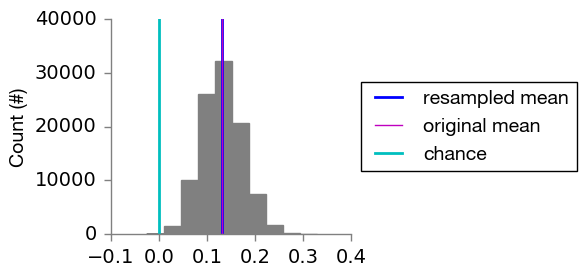

Memory performance better for trials triggered due to slow RTs vs. fast RTs: p = 2.20E-04
Fails to reject the null hypothesis that the data is normally distributed, p = 0.16
Parametric statistical result: T = 3.1, p = 5.6E-03


In [19]:
# Compute statistics 

data = propRememTriggeredSlow-propRememTriggeredFast
chance = 0

#non-parametric - by resampling participants with replacement
resampledA,p = resamplingStatistics(data,chance,nSubj,nSamples)
print "Memory performance better for trials triggered due to slow RTs vs. fast RTs: p = %.2E" %p

#parametric
paramStatistics(data,chance)

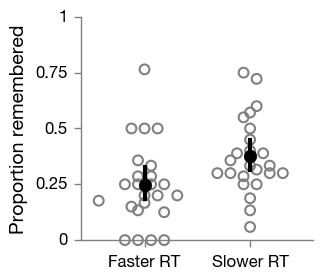

In [20]:
#plot memory proportion for trials triggered based on faster vs. slower RTs

fig = plt.figure(figsize=(6,3))
gs = plt.GridSpec(1,2)
ax0 = plt.subplot(gs[0])
x = np.zeros(24)
y = propRememTriggeredFast
x_swarm,a,b = plotSpread(x,y)
ax0.scatter(x_swarm+.375,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
x = np.zeros(24)
y = propRememTriggeredSlow
x_swarm,a,b = plotSpread(x,y)
ax0.scatter(x_swarm+.625,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
make_plot_pretty(ax0,xt=(.375,.625),yt=(0,.25,.5,.75,1),ytl=(0,.25,.5,.75,1),xlim=(.225,.775),ylim=(0,1),xtl=('Faster RT','Slower RT'),yl=('Proportion remembered'))
ax0.plot((.375,.625),((propRememTriggeredFast).mean(),(propRememTriggeredSlow).mean()),'o',color='k',markersize=9);
ax0.plot([.375,.375], propRememTriggeredFast_CIs, 'k-',linewidth=3);
ax0.plot([.625,.625], propRememTriggeredSlow_CIs, 'k-',linewidth=3);

In [21]:
propRememTriggeredFastAcc_CIs = bootstrap.ci(data=(propRememTriggeredFastAcc[np.where(subjCorrBothConds==1)]), statfunction=scipy.mean,n_samples=nSamples)
propRememTriggeredSlowAcc_CIs = bootstrap.ci(data=(propRememTriggeredSlowAcc[np.where(subjCorrBothConds==1)]), statfunction=scipy.mean,n_samples=nSamples)

print "Memory performance for trials triggered due to fast RTs (accurate responses in first part):"
print "Proportion remembered = %d%%, \t95%% CIs %.0f,%.0f%%" % ( round(np.ndarray.mean(propRememTriggeredFastAcc[np.where(subjCorrBothConds==1)]),2)*100,round(propRememTriggeredFastAcc_CIs[0],2)*100,round(propRememTriggeredFastAcc_CIs[1],2)*100 )
print "\n"
print "Memory performance for trials triggered due to slow RTs (accurate responses in first part):"
print "Proportion remembered = %d%%, \t95%% CIs %.0f,%.0f%%" % ( round(np.ndarray.mean(propRememTriggeredSlowAcc[np.where(subjCorrBothConds==1)]),2)*100,round(propRememTriggeredSlowAcc_CIs[0],2)*100,round(propRememTriggeredSlowAcc_CIs[1],2)*100 )

Memory performance for trials triggered due to fast RTs (accurate responses in first part):
Proportion remembered = 26%, 	95% CIs 17,40%


Memory performance for trials triggered due to slow RTs (accurate responses in first part):
Proportion remembered = 40%, 	95% CIs 32,49%


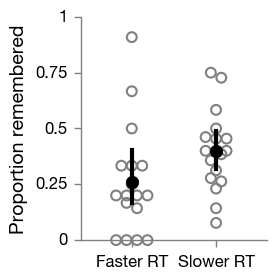

In [22]:
#plot proportion remembered for trials triggered based on faster vs. slower RTs, correct responses only

fig = plt.figure(figsize=(3,3))
gs = plt.GridSpec(1,1)
ax0 = plt.subplot(gs[0])
x = np.zeros(np.sum(subjCorrBothConds==1))
y = propRememTriggeredFastAcc[np.where(subjCorrBothConds==1)]
x_swarm,a,b = plotSpread(x,y)
ax0.scatter(x_swarm+.375,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
x = np.zeros(np.sum(subjCorrBothConds==1))
y = propRememTriggeredSlowAcc[np.where(subjCorrBothConds==1)]
x_swarm,a,b = plotSpread(x,y)
ax0.scatter(x_swarm+.625,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
make_plot_pretty(ax0,xt=(.375,.625),yt=(0,.25,.5,.75,1),ytl=(0,.25,.5,.75,1),xlim=(.225,.775),ylim=(0,1),xtl=('Faster RT','Slower RT'),yl=('Proportion remembered'))
ax0.plot((.375,.625),((propRememTriggeredFastAcc[np.where(subjCorrBothConds==1)]).mean(),(propRememTriggeredSlowAcc[np.where(subjCorrBothConds==1)]).mean()),'o',color='k',markersize=9);
ax0.plot([.375,.375], propRememTriggeredFastAcc_CIs, 'k-',linewidth=3);
ax0.plot([.625,.625], propRememTriggeredSlowAcc_CIs, 'k-',linewidth=3);

savefig(fig,'figure4c')

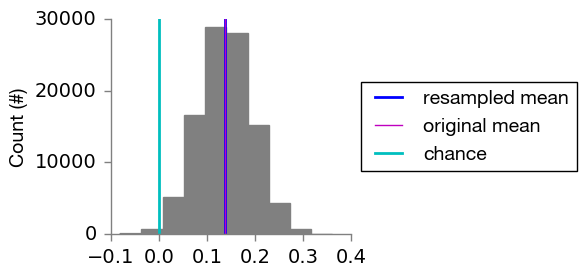

Memory performance better for trials triggered due to slow RTs vs. fast RTs (Correct repsonses only): p = 5.55E-03
Fails to reject the null hypothesis that the data is normally distributed, p = 0.98
Parametric statistical result: T = 2.4, p = 2.8E-02


In [23]:
#Compute  statistics

data = propRememTriggeredSlowAcc[np.where(subjCorrBothConds==1)]-propRememTriggeredFastAcc[np.where(subjCorrBothConds==1)]
chance = 0

#non-parametric
resampled,p = resamplingStatistics(data,chance,np.sum(subjCorrBothConds).astype(int),nSamples)
print "Memory performance better for trials triggered due to slow RTs vs. fast RTs (Correct repsonses only): p = %.2E" %p

#parametric
paramStatistics(data,chance)

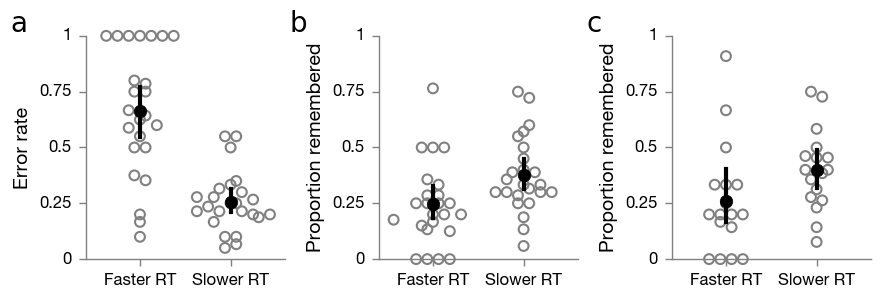

In [24]:
#plot data for trials triggered based on faster vs. slower RTs

#attention data
fig = plt.figure(figsize=(9,3))
gs = plt.GridSpec(1,3)
ax0 = plt.subplot(gs[0])
x = np.zeros(24)
y = faTriggeredFast
x_swarm,a,b = plotSpread(x,y)
ax0.scatter(x_swarm+.375,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
x = np.zeros(24)
y = faTriggeredSlow
x_swarm,a,b = plotSpread(x,y)
ax0.scatter(x_swarm+.625,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
make_plot_pretty(ax0,xt=(.375,.625),yt=(0,.25,.5,.75,1),ytl=(0,.25,.5,.75,1),xlim=(.225,.775),ylim=(0,1),xtl=('Faster RT','Slower RT'),yl=('Error rate'))
ax0.plot((.375,.625),((faTriggeredFast).mean(),(faTriggeredSlow).mean()),'o',color='k',markersize=9);
ax0.plot([.375,.375], faTriggeredFast_CIs, 'k-',linewidth=3);
ax0.plot([.625,.625], faTriggeredSlow_CIs, 'k-',linewidth=3);

#memory data
ax1 = plt.subplot(gs[1])
x = np.zeros(24)
y = propRememTriggeredFast
x_swarm,a,b = plotSpread(x,y)
ax1.scatter(x_swarm+.375,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
x = np.zeros(24)
y = propRememTriggeredSlow
x_swarm,a,b = plotSpread(x,y)
ax1.scatter(x_swarm+.625,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
make_plot_pretty(ax1,xt=(.375,.625),yt=(0,.25,.5,.75,1),ytl=(0,.25,.5,.75,1),xlim=(.225,.775),ylim=(0,1),xtl=('Faster RT','Slower RT'),yl=('Proportion remembered'))
ax1.plot((.375,.625),((propRememTriggeredFast).mean(),(propRememTriggeredSlow).mean()),'o',color='k',markersize=9);
ax1.plot([.375,.375], propRememTriggeredFast_CIs, 'k-',linewidth=3);
ax1.plot([.625,.625], propRememTriggeredSlow_CIs, 'k-',linewidth=3);

#memory data, correct responses only
ax2 = plt.subplot(gs[2])
x = np.zeros(np.sum(subjCorrBothConds==1))
y = propRememTriggeredFastAcc[np.where(subjCorrBothConds==1)]
x_swarm,a,b = plotSpread(x,y)
ax2.scatter(x_swarm+.375,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
x = np.zeros(np.sum(subjCorrBothConds==1))
y = propRememTriggeredSlowAcc[np.where(subjCorrBothConds==1)]
x_swarm,a,b = plotSpread(x,y)
ax2.scatter(x_swarm+.625,y,s=50,facecolors='none',edgecolors='gray',linewidth=1.5,clip_on=False)
make_plot_pretty(ax2,xt=(.375,.625),yt=(0,.25,.5,.75,1),ytl=(0,.25,.5,.75,1),xlim=(.225,.775),ylim=(0,1),xtl=('Faster RT','Slower RT'),yl=('Proportion remembered'))
ax2.plot((.375,.625),((propRememTriggeredFastAcc[np.where(subjCorrBothConds==1)]).mean(),(propRememTriggeredSlowAcc[np.where(subjCorrBothConds==1)]).mean()),'o',color='k',markersize=9);
ax2.plot([.375,.375], propRememTriggeredFastAcc_CIs, 'k-',linewidth=3);
ax2.plot([.625,.625], propRememTriggeredSlowAcc_CIs, 'k-',linewidth=3);

fig.text(.02, .92, "a", fontweight='medium',size=20)
fig.text(.33, .92, "b", fontweight='medium',size=20)
fig.text(.66, .92, "c", fontweight='medium',size=20)

savefig(fig,'figure4')